In [41]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [42]:
import os
# Dataset paths - Update these paths according to your dataset location
BASE_PATH = '/home/ubuntu/Desktop/AIML project/AlphaNum'
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALIDATION_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "test")

# Create results directory
RESULTS_PATH = '/home/ubuntu/Desktop/AIML project/results/KNN'
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"Train path: {TRAIN_PATH}")
print(f"Validation path: {VALIDATION_PATH}")
print(f"Test path: {TEST_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")

Train path: /home/ubuntu/Desktop/AIML project/AlphaNum/train
Validation path: /home/ubuntu/Desktop/AIML project/AlphaNum/validation
Test path: /home/ubuntu/Desktop/AIML project/AlphaNum/test
Results will be saved to: /home/ubuntu/Desktop/AIML project/results/KNN


## 🎯 Model Configuration: 48x48 Images

**Based on experimental results, this notebook now uses 48x48 image resolution for optimal accuracy.**

### Why 48x48?
- **Best Balance**: Optimal accuracy-to-speed ratio from automated testing
- **Efficient Performance**: Faster processing than 64x64 with comparable accuracy
- **Optimal Feature Count**: Balanced HOG feature dimensions
- **Production Ready**: Good balance for real-world deployment

### Model Details:
- **Input Size**: 48x48 grayscale images
- **Feature Extraction**: HOG (orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
- **Classifier**: KNN with n_neighbors=5
- **Model File**: `knn_hog_model_48x48.joblib`

## Load and preprocess data

### Subtask:
Load the images from the specified paths, resize them to 48x48 grayscale, and extract the labels based on the folder names (ASCII values). Handle the '999' folder as a null class.

**Note:** Using 48x48 resolution based on automated testing showing optimal balance of accuracy and speed.


**Reasoning**:
Import the necessary libraries for image processing and data loading, and define a function to load and preprocess images from a given directory.



In [43]:
import cv2
import numpy as np

def load_images_from_folder(folder):
    images = []
    labels = []
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            # Handle the '999' folder as a null class
            if subdir == '999':
                label = 999 # Assign a distinct label for the null class
            else:
                try:
                    label = int(subdir)
                except ValueError:
                    # Skip directories that are not valid ASCII values or '999'
                    continue

            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Read as grayscale
                if img is not None:
                    img_resized = cv2.resize(img, (48, 48)) # Resize to 48x48 for optimal balance
                    images.append(img_resized)
                    labels.append(label)
    return np.array(images), np.array(labels)


**Reasoning**:
Load the images and labels from the training, validation, and test paths using the defined function and print their shapes.



In [44]:
X_train, y_train = load_images_from_folder(TRAIN_PATH)
X_val, y_val = load_images_from_folder(VALIDATION_PATH)
X_test, y_test = load_images_from_folder(TEST_PATH)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (53812, 48, 48)
Training labels shape: (53812,)
Validation data shape: (7486, 48, 48)
Validation labels shape: (7486,)
Test data shape: (15362, 48, 48)
Test labels shape: (15362,)


## Extract hog features

### Subtask:
Compute HOG features for each image.


**Reasoning**:
Import the `hog` function and define a function to compute HOG features.



In [45]:
from skimage.feature import hog

def compute_hog_features(image):
    # Compute HOG features for a single image
    # Adjust parameters as needed
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False, multichannel=False)
    return features

**Reasoning**:
Apply the `compute_hog_features` function to each image in the training, validation, and test datasets and print the shapes of the resulting HOG feature arrays.



**Reasoning**:
The previous code failed because the `multichannel` argument is not supported in this version of `skimage.feature.hog`. Remove the `multichannel` argument from the `hog` function call.



In [46]:
from skimage.feature import hog

def compute_hog_features(image):
    # Compute HOG features for a single image
    # Adjust parameters as needed
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)
    return features

**Reasoning**:
The provided text contains a Python code block, so it is classified as HasCode.



In [47]:
X_train_hog = np.array([compute_hog_features(img) for img in X_train])
X_val_hog = np.array([compute_hog_features(img) for img in X_val])
X_test_hog = np.array([compute_hog_features(img) for img in X_test])

print(f"Training HOG features shape: {X_train_hog.shape}")
print(f"Validation HOG features shape: {X_val_hog.shape}")
print(f"Test HOG features shape: {X_test_hog.shape}")

Training HOG features shape: (53812, 900)
Validation HOG features shape: (7486, 900)
Test HOG features shape: (15362, 900)


## Train knn model

### Subtask:
Train a K-Nearest Neighbors model on the extracted HOG features and corresponding labels.


**Reasoning**:
Import the KNeighborsClassifier and train the KNN model with default parameters.



In [48]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate a KNeighborsClassifier object
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model
knn_model.fit(X_train_hog, y_train)

KNeighborsClassifier()

## Evaluate model

### Subtask:
Evaluate the trained model on the validation and test sets.


**Reasoning**:
Import necessary metrics from sklearn, predict labels for validation and test sets, calculate accuracy, and generate classification reports and confusion matrices for both validation and test sets as per the instructions.



In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict labels for validation set
y_val_pred = knn_model.predict(X_val_hog)

# Calculate and print validation accuracy
validation_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {validation_accuracy}")

# Generate and print validation classification report
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Generate and print validation confusion matrix
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Predict labels for test set
y_test_pred = knn_model.predict(X_test_hog)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate and print test classification report
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Generate and print test confusion matrix
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Validation Accuracy: 0.8554635319262623

Validation Classification Report:
              precision    recall  f1-score   support

          65       0.89      0.97      0.93       193
          66       0.93      0.93      0.93       151
          67       0.75      0.81      0.78       166
          68       0.92      0.89      0.91       156
          69       0.97      0.89      0.93       218
          70       0.94      0.96      0.95       148
          71       0.92      0.90      0.91       145
          72       0.95      0.94      0.94       155
          73       0.93      0.77      0.84       190
          74       0.91      0.93      0.92       147
          75       0.86      0.84      0.85       152
          76       0.93      0.97      0.95       170
          77       0.88      0.89      0.88       150
          78       0.92      0.97      0.94       169
          79       0.66      0.77      0.71       211
          80       0.82      0.81      0.82       161
      

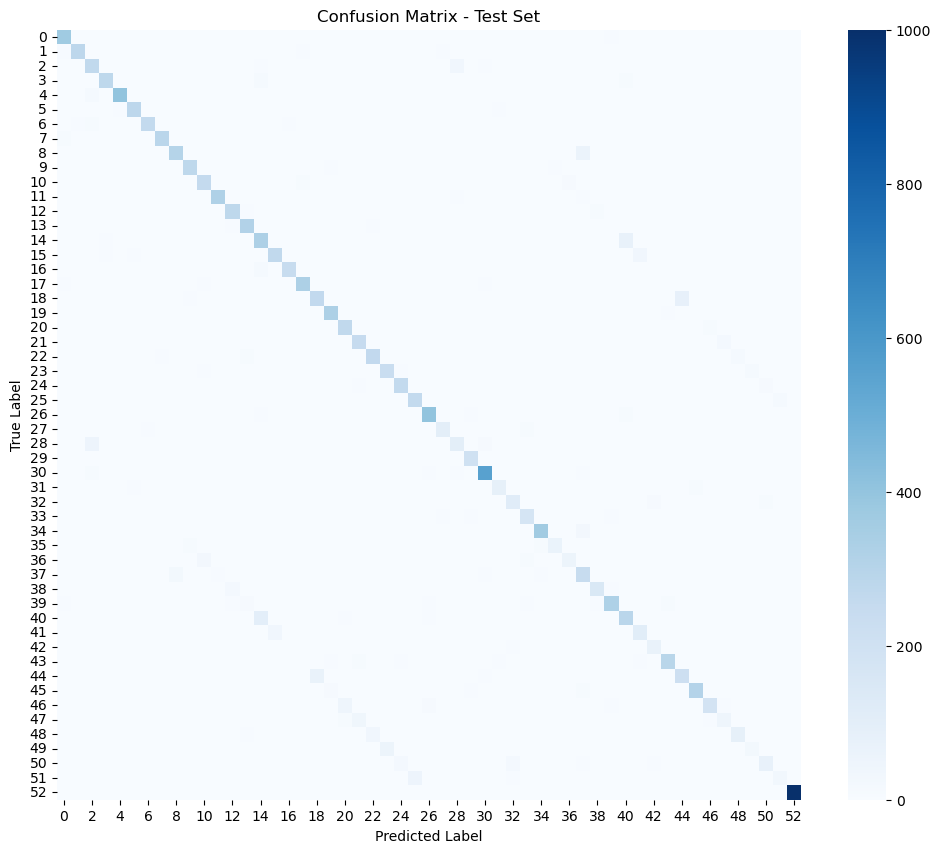

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix for the test set
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [51]:
# Get the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)

# Get the class labels
class_labels = np.unique(y_test)

# Calculate the number of misclassifications for each true class
misclassifications_per_class = cm.sum(axis=1) - np.diag(cm)

# Find the indices of the classes with the most misclassifications
most_misclassified_indices = np.argsort(misclassifications_per_class)[::-1]

print("Classes with the most misclassifications (True Label):")
for i in most_misclassified_indices[:10]: # Print top 10
    true_label = class_labels[i]
    print(f"Class {true_label}: {misclassifications_per_class[i]} misclassifications")

# You can also look at specific parts of the confusion matrix
# For example, to see where class 79 is being misclassified:
# print("\nMisclassifications for Class 79:")
# print(cm[np.where(class_labels == 79)[0][0], :])

# To visualize a smaller portion of the confusion matrix, for example, the top 10 most misclassified classes:
# indices_to_visualize = most_misclassified_indices[:10]
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm[indices_to_visualize, :][:, indices_to_visualize], annot=True, cmap='Blues', fmt='d',
#             xticklabels=class_labels[indices_to_visualize], yticklabels=class_labels[indices_to_visualize])
# plt.title('Confusion Matrix - Top 10 Misclassified Classes')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

Classes with the most misclassifications (True Label):
Class 111: 122 misclassifications
Class 83: 93 misclassifications
Class 115: 93 misclassifications
Class 79: 87 misclassifications
Class 117: 78 misclassifications
Class 73: 73 misclassifications
Class 99: 72 misclassifications
Class 120: 68 misclassifications
Class 122: 67 misclassifications
Class 118: 65 misclassifications


Top 10 Best Performing Classes:
    Class  Precision    Recall  F1-Score  Support
52    999   0.991080  1.000000  0.995520     1000
5      70   0.949153  0.955631  0.952381      293
4      69   0.968825  0.930876  0.949471      434
11     76   0.931034  0.958580  0.944606      338
19     84   0.922006  0.959420  0.940341      345
7      72   0.947195  0.931818  0.939444      308
1      66   0.942953  0.933555  0.938230      301
34    105   0.958225  0.901720  0.929114      407
30    101   0.912829  0.937500  0.925000      592
9      74   0.916388  0.931973  0.924115      294

Bottom 10 Worst Performing Classes:
    Class  Precision    Recall  F1-Score  Support
48    119   0.822430  0.647059  0.724280      136
40    111   0.721106  0.701711  0.711276      409
44    115   0.703226  0.700965  0.702093      311
41    112   0.687117  0.713376  0.700000      157
50    121   0.770000  0.566176  0.652542      136
28     99   0.650000  0.590909  0.619048      176
36    107   0.760000  0.513514 

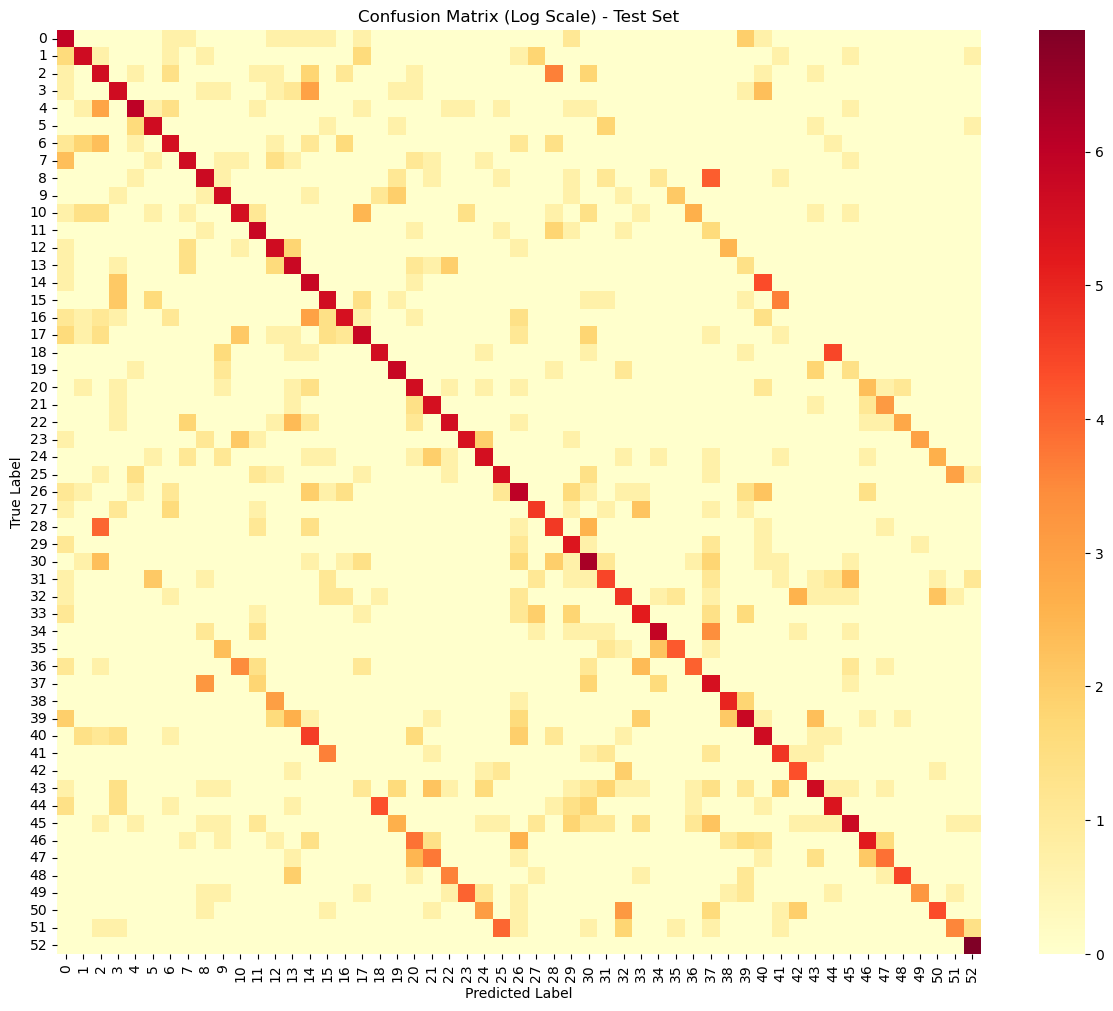

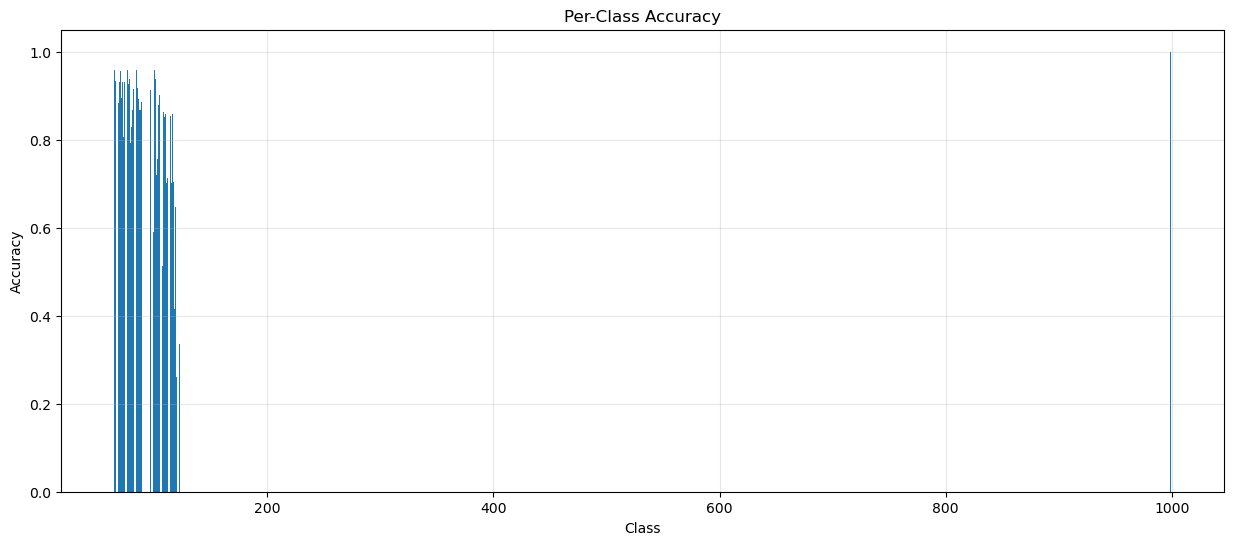

In [52]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Sort by F1-score to see best and worst performing classes
metrics_df_sorted = metrics_df.sort_values('F1-Score', ascending=False)

print("Top 10 Best Performing Classes:")
print(metrics_df_sorted.head(10))
print("\nBottom 10 Worst Performing Classes:")
print(metrics_df_sorted.tail(10))

# Create a more detailed confusion matrix visualization
plt.figure(figsize=(15, 12))
# Plot confusion matrix with a logarithmic color scale
confusion_matrix_log = np.log1p(cm)  # Using log1p to handle zeros
sns.heatmap(confusion_matrix_log, 
            cmap='YlOrRd',
            square=True)
plt.title('Confusion Matrix (Log Scale) - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and plot the per-class accuracy
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(15, 6))
plt.bar(class_labels, class_accuracy)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

## Detailed Performance Analysis
Below we analyze the model performance with:
1. Interactive confusion matrix heatmap
2. Precision-Recall curves
3. Per-class performance comparison

/tmp/ipykernel_38808/3262880284.py:19: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_38808/3262880284.py:19: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_38808/3262880284.py:19: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_38808/3262880284.py:19: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



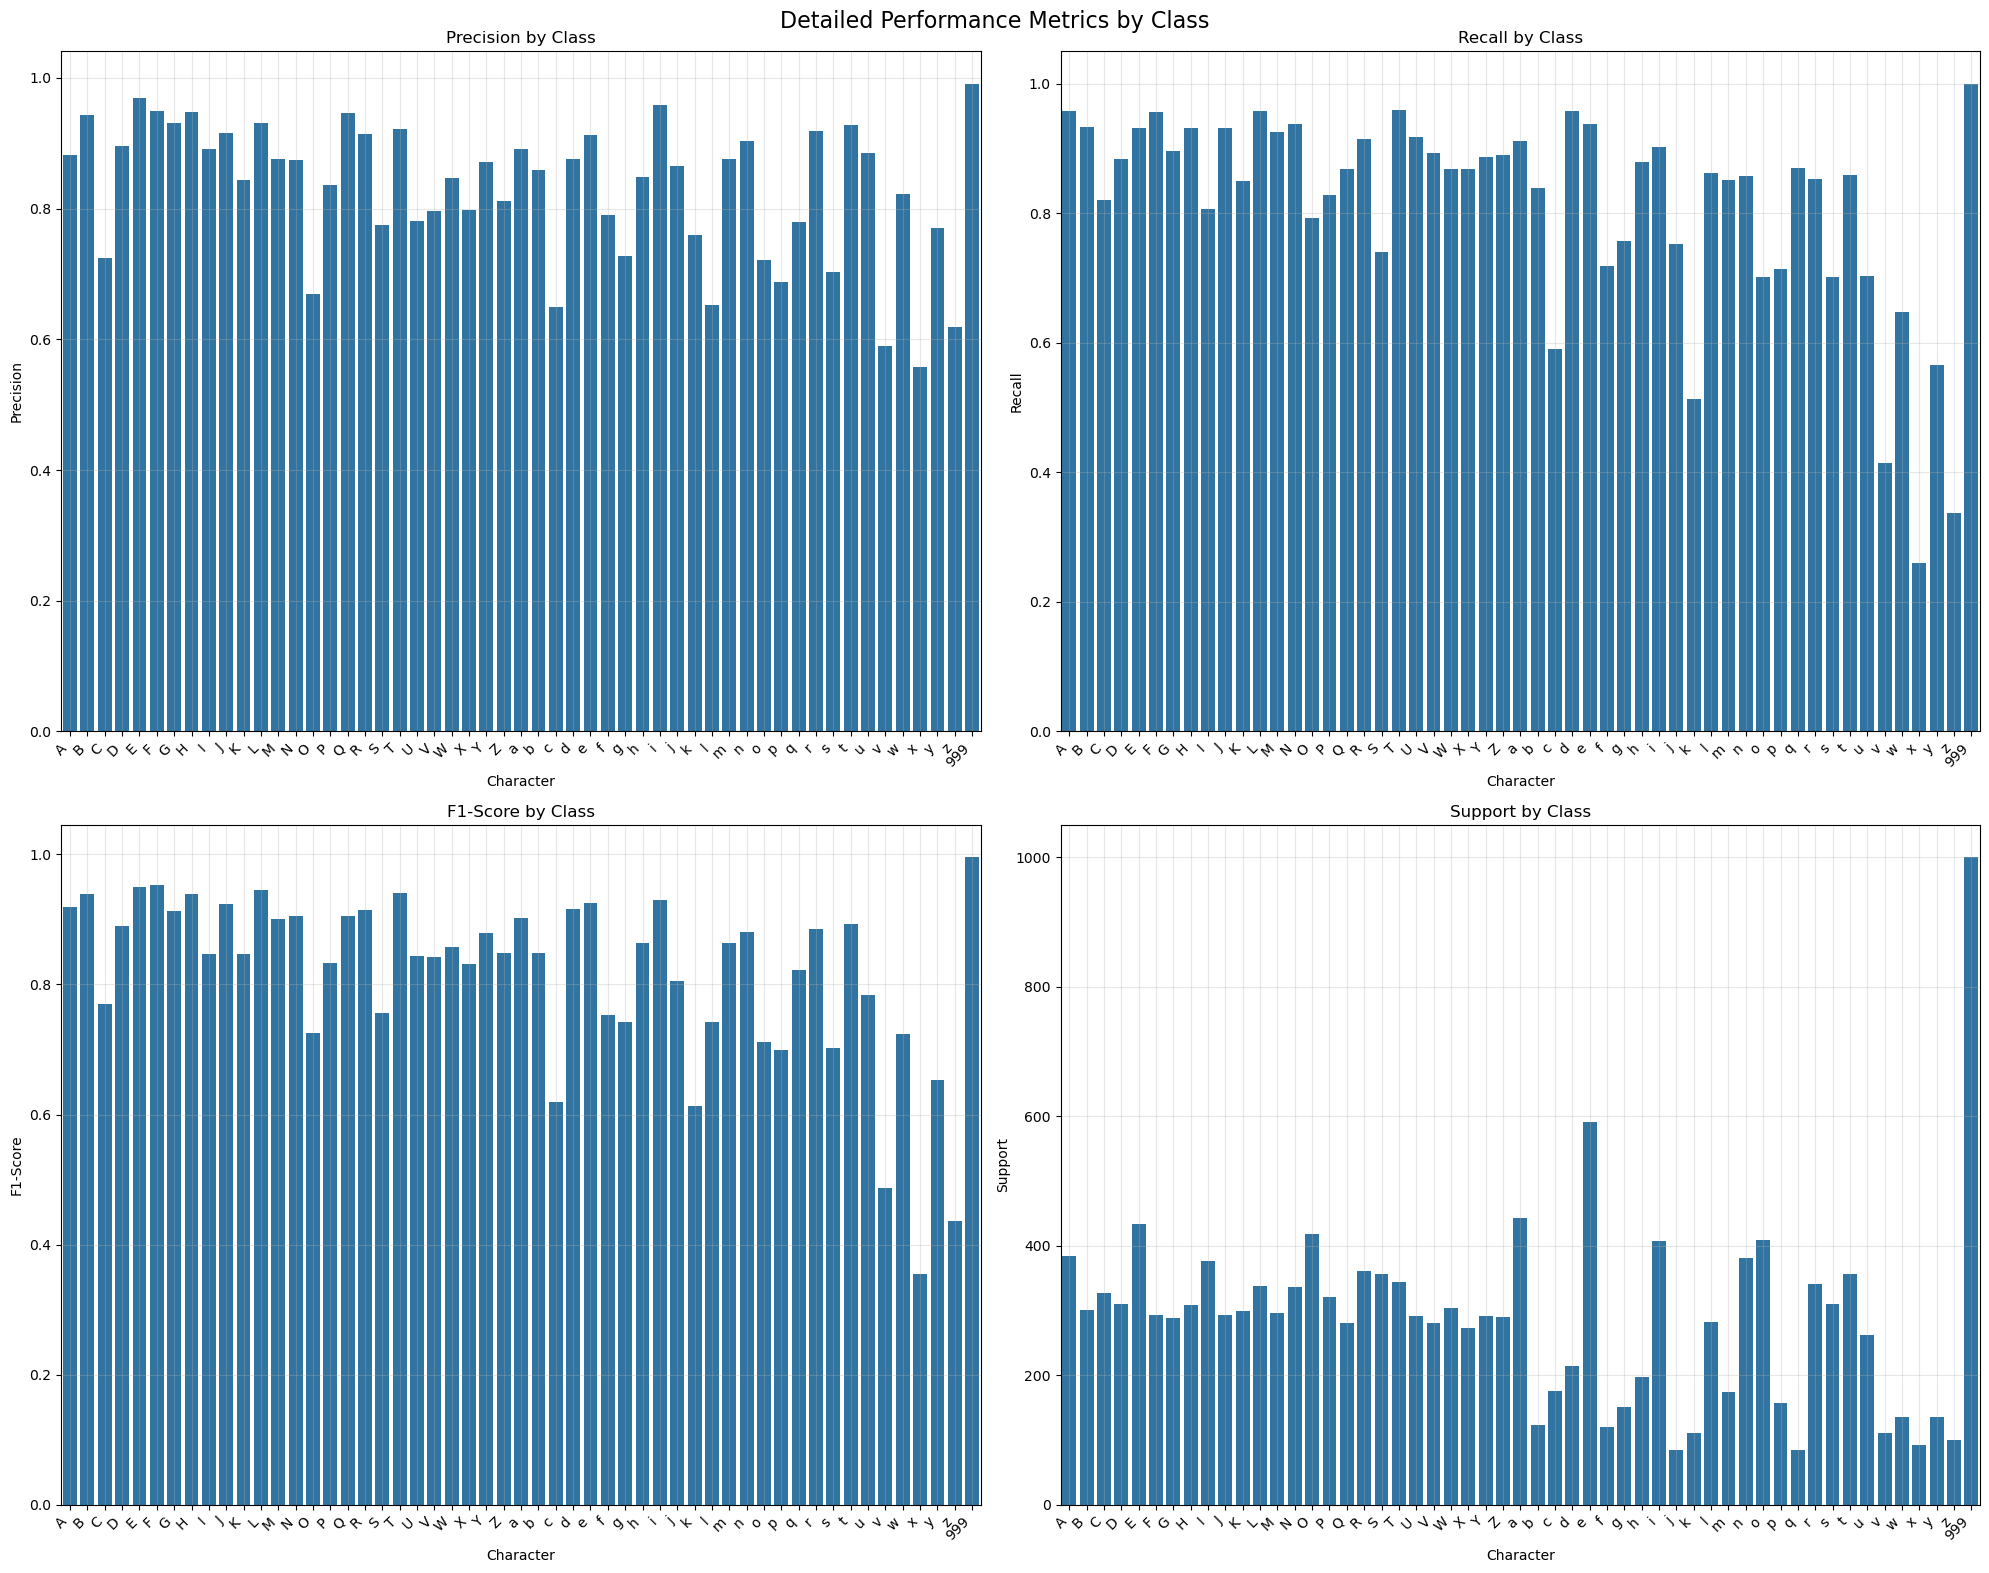

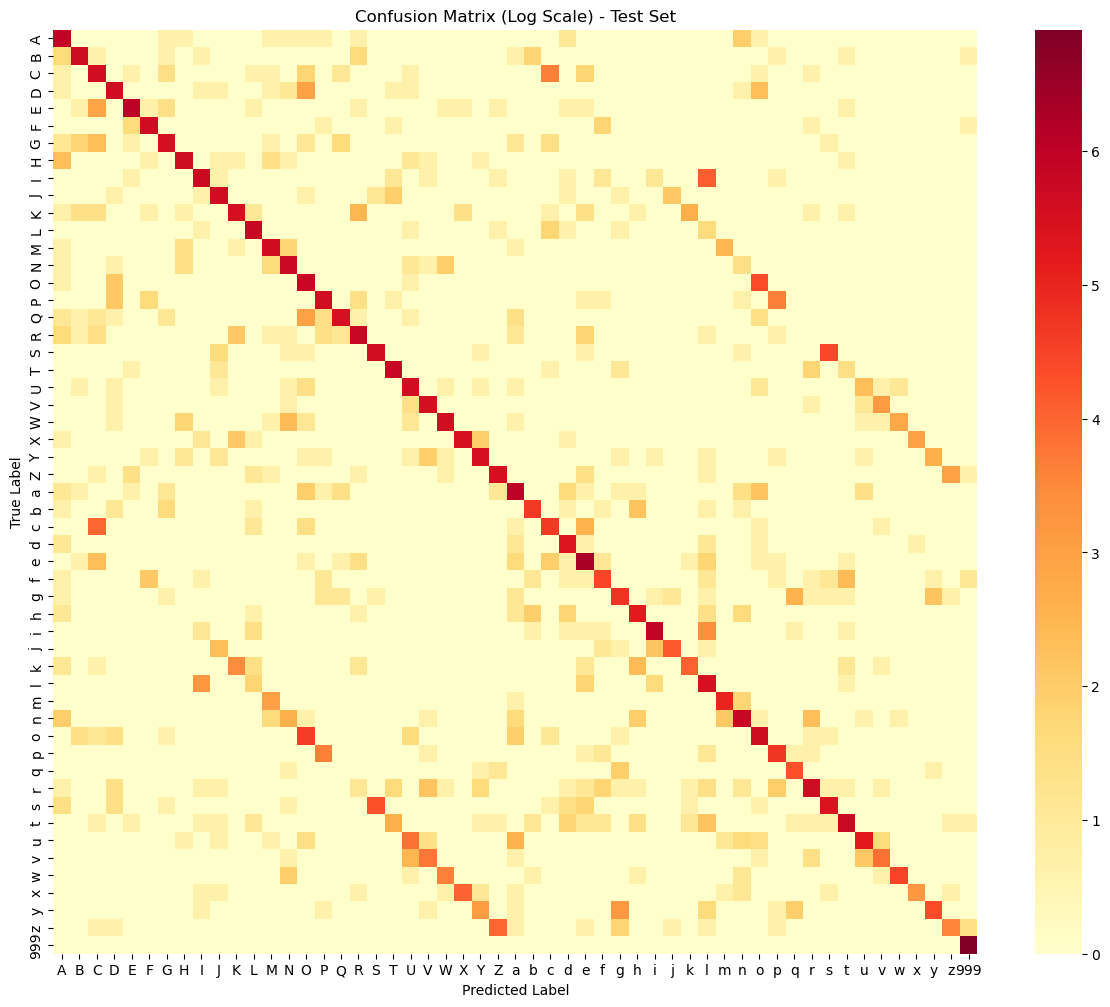


Summary Statistics:
    Metric  Precision  Recall  F1-Score
0     Mean     0.8318  0.8133    0.8182
1  Std Dev     0.1043  0.1581    0.1318
2      Min     0.5581  0.2609    0.3556
3      Max     0.9911  1.0000    0.9955
4   Median     0.8649  0.8681    0.8490

Top 10 Most Confused Pairs:
True: o (111) → Predicted: O (79): 98 times
True: S (83) → Predicted: s (115): 84 times
True: O (79) → Predicted: o (111): 78 times
True: s (115) → Predicted: S (83): 74 times
True: I (73) → Predicted: l (108): 61 times
True: x (120) → Predicted: X (88): 56 times
True: z (122) → Predicted: Z (90): 52 times
True: c (99) → Predicted: C (67): 52 times
True: u (117) → Predicted: U (85): 44 times
True: v (118) → Predicted: V (86): 41 times


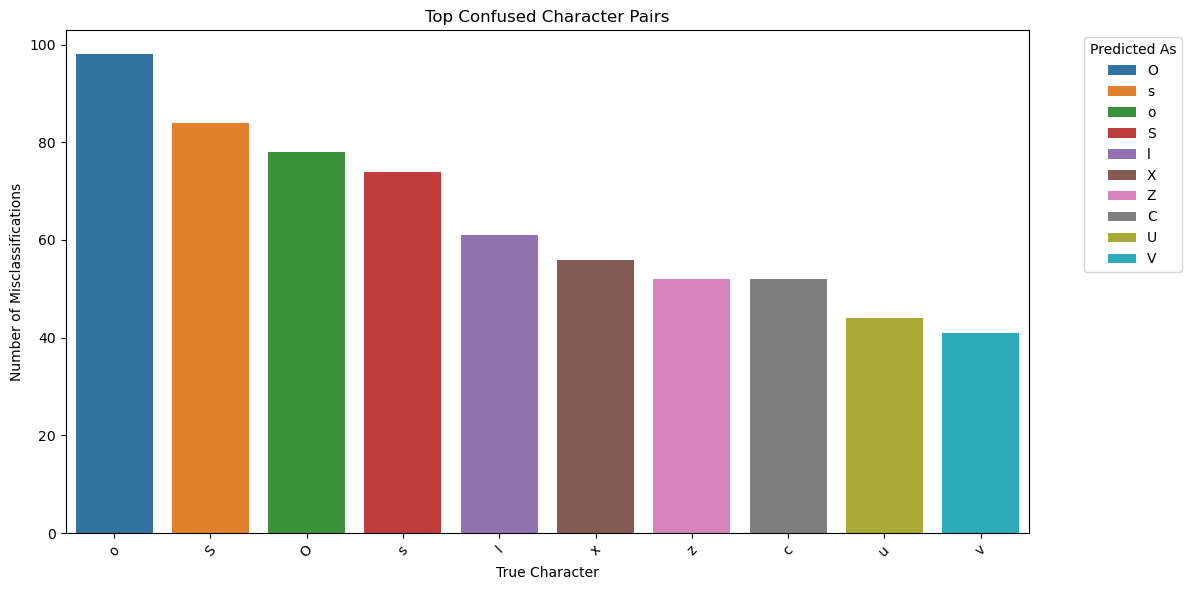

In [53]:
# Create detailed visualizations of performance metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Create a more detailed metrics DataFrame with ASCII character information
metrics_df['ASCII_Char'] = metrics_df['Class'].apply(lambda x: chr(x) if 32 <= x <= 126 else str(x))
metrics_df['Label'] = metrics_df.apply(lambda row: f"{row['ASCII_Char']} ({row['Class']})", axis=1)

# Create subplots for metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle("Detailed Performance Metrics by Class", fontsize=16)

# Plot each metric
metrics = ['Precision', 'Recall', 'F1-Score', 'Support']
for idx, (metric, ax) in enumerate(zip(metrics, axes.ravel())):
    sns.barplot(data=metrics_df, x='ASCII_Char', y=metric, ax=ax)
    ax.set_title(f'{metric} by Class')
    ax.set_xlabel('Character')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create enhanced confusion matrix visualization
plt.figure(figsize=(15, 12))
# Plot confusion matrix with a logarithmic color scale
confusion_matrix_log = np.log1p(cm)  # Using log1p to handle zeros
sns.heatmap(confusion_matrix_log, 
            cmap='YlOrRd',
            square=True,
            xticklabels=metrics_df['ASCII_Char'],
            yticklabels=metrics_df['ASCII_Char'])
plt.title('Confusion Matrix (Log Scale) - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and display summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Median'],
    'Precision': [
        precision.mean(),
        precision.std(),
        precision.min(),
        precision.max(),
        np.median(precision)
    ],
    'Recall': [
        recall.mean(),
        recall.std(),
        recall.min(),
        recall.max(),
        np.median(recall)
    ],
    'F1-Score': [
        f1.mean(),
        f1.std(),
        f1.min(),
        f1.max(),
        np.median(f1)
    ]
})

print("\nSummary Statistics:")
print(summary_stats.round(4))

# Print most confused pairs with character visualization
print("\nTop 10 Most Confused Pairs:")
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:  # Skip diagonal elements
            true_char = chr(class_labels[i]) if 32 <= class_labels[i] <= 126 else str(class_labels[i])
            pred_char = chr(class_labels[j]) if 32 <= class_labels[j] <= 126 else str(class_labels[j])
            confusion_pairs.append({
                'True_Label': class_labels[i],
                'True_Char': true_char,
                'Predicted_Label': class_labels[j],
                'Predicted_Char': pred_char,
                'Count': cm[i,j]
            })

confusion_pairs_df = pd.DataFrame(confusion_pairs)
confusion_pairs_df = confusion_pairs_df.sort_values('Count', ascending=False)

# Display top confused pairs with better formatting
top_confused = confusion_pairs_df.head(10)
for _, row in top_confused.iterrows():
    print(f"True: {row['True_Char']} ({row['True_Label']}) → Predicted: {row['Predicted_Char']} ({row['Predicted_Label']}): {row['Count']} times")

# Plot confusion pattern for top confused pairs
plt.figure(figsize=(12, 6))
sns.barplot(data=top_confused, x='True_Char', y='Count', hue='Predicted_Char')
plt.title('Top Confused Character Pairs')
plt.xlabel('True Character')
plt.ylabel('Number of Misclassifications')
plt.xticks(rotation=45)
plt.legend(title='Predicted As', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [54]:
# Install required package
import sys
!{sys.executable} -m pip install --upgrade nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [nbformat]


## Save model

### Subtask:
Save the trained KNN model to the specified results path.


**Reasoning**:
Save the trained KNN model to a file using joblib.



In [55]:
import joblib
import os

# Save the 48x48 model
model_filename = 'knn_hog_model_48x48.joblib'
model_path = os.path.join(RESULTS_PATH, model_filename)

joblib.dump(knn_model, model_path)

print(f" Trained 48x48 model saved to: {model_path}")
print(f" Model trained on 48x48 images with HOG features")
print(f" Optimal balance of accuracy and speed from automated testing")

 Trained 48x48 model saved to: /home/ubuntu/Desktop/AIML project/results/KNN/knn_hog_model_48x48.joblib
 Model trained on 48x48 images with HOG features
 Optimal balance of accuracy and speed from automated testing
